# Chapter 03 — Raw Reads and Downsampling

## Objective

In this chapter, we load all single-nucleus RNA-seq datasets required for benchmarking the **Singulator + FACS** and **Singulator + LeviCell** protocols. We also verify metadata consistency, perform basic integrity checks, and prepare the data objects for downstream analysis.

This includes:

- Locating the data on the shared filesystem (Iris)
- Loading raw count matrices (e.g., `filtered_feature_bc_matrix.h5` from 10X)
- Loading data into `AnnData` objects

## Data Source

The data for this benchmarking project is stored on the **Iris** HPC filesystem under:

`/data1/collab002/sail/isabl/datalake/prod/010/collaborators/SAIL/projects/singulator_debris_removal_and/experiments`

We will be working with the data under identifier `MB-4027_*`


## Core Imports

In [2]:
import os
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
from typing import Callable, Dict, List, Tuple
import gzip
import polars as pl

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/leidenalg/VertexPartition.py:413: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\frac{1}{m} \\sum_{ij} \\left(A_{ij} - \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/leidenalg/VertexPartition.py:788: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\sum_{ij} \\left(A_{ij} - \\gamma \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/leidenalg/Optimiser.py:27: SyntaxWarning: invalid escape sequence '\g'
  implementation therefore does not guarantee subpartition :math:`\gamma`-density.
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/leidenalg/Optimiser.py:346: SyntaxWarning: invalid escape

## File Paths and Metadata

In [8]:
# Constants
DATA_DIR = "./data"
READ_ONLY_DIR = os.path.join(DATA_DIR, "read_only")
FIGURES_OUTPUT_DIR = os.path.join(
    DATA_DIR, "figures", "chapter_03_raw_reads_and_downsampling"
)
ANALYSIS_DIR = os.path.join(DATA_DIR, "analysis")
INPUT_ADATA_DIR = os.path.join(ANALYSIS_DIR, "adatas", "chapter_02_no_filter_analysis")
OUTPUT_ADATA_DIR = os.path.join(
    ANALYSIS_DIR, "adatas", "chapter_03_raw_reads_and_downsampling"
)
GENE_SETS_DIR = os.path.join(DATA_DIR, "gene_sets_and_info")

MOLECULE_INFO_FILE_NAME = "molecule_info.h5"
FILTERED_BARCODES_FILE_NAME = "filtered_feature_bc_matrix/barcodes.tsv.gz"

# Make sure output directories exist
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_ADATA_DIR, exist_ok=True)

# Sample metadata - in data/metadata.tsv
samples = {
    "SF_N": ("MB-4027_SF_N", "Normal Colon", "Singulator+FACS"),
    "SL_N": ("MB-4027_SL_N", "Normal Colon", "Singulator+LeviCell"),
    "SF_T": ("MB-4027_SF_T", "Tumor Colon", "Singulator+FACS"),
    "SL_T": ("MB-4027_SL_T", "Tumor Colon", "Singulator+LeviCell"),
    "SF_LN": ("MB-4027_SF_LN", "Normal Liver", "Singulator+FACS"),
    "SL_LN": ("MB-4027_SL_LN", "Normal Liver", "Singulator+LeviCell"),
}

# Color palette for plotting
protocol_color_palette = {
    "Singulator+FACS": "#AEC6CF",
    "Singulator+LeviCell": "#FFDAB9",
}

## Read in Molecule Info files

### Functions

In [24]:
def read_molecule_info(file_path: str) -> pl.DataFrame:
    """
    Load molecule_info.h5 and return a Polars DataFrame with cell barcodes, UMIs, read counts, and gene IDs.

    Parameters:
        file_path (str): Path to the molecule_info.h5 file.

    Returns:
        pl.DataFrame: DataFrame with columns ['cell', 'umi', 'reads', 'gene_id'].
    """
    with h5py.File(file_path, "r") as f:
        barcode_idx = f["barcode_idx"][:]
        umi = f["umi"][:]
        gene_idx = f["feature_idx"][:]
        reads = f["count"][:]
        barcodes = np.array([b.decode("utf-8") for b in f["barcodes"][:]])
        gene_ids = np.array([g.decode("utf-8") for g in f["features"]["id"][:]])

    # Map indices to actual barcode and gene strings
    return pl.DataFrame(
        {
            "cell": barcodes[barcode_idx],
            "umi": umi,
            "reads": reads,
            "gene_id": gene_ids[gene_idx],
        }
    )

In [ ]:
# Load Molecule Info as Polars DataFrames
molecule_infos = {}
molecule_info_metadata = {}

for key, (folder, tissue, protocol) in samples.items():
    file_path = os.path.join(
        READ_ONLY_DIR,
        folder,
        f"analyses/CellRangerGex-9.0.0-{folder}/outputs",
        MOLECULE_INFO_FILE_NAME,
    )
    molecule_info = read_molecule_info(file_path)
    molecule_infos[key] = molecule_info
    molecule_info_metadata[key] = (tissue, protocol)
    print(f"{key}: {molecule_info}")

SF_N: shape: (43_437_252, 4)
┌──────────────────┬──────────┬───────┬─────────────────┐
│ cell             ┆ umi      ┆ reads ┆ gene_id         │
│ ---              ┆ ---      ┆ ---   ┆ ---             │
│ str              ┆ u32      ┆ u32   ┆ str             │
╞══════════════════╪══════════╪═══════╪═════════════════╡
│ AAACCCAAGAAACTAC ┆ 8610835  ┆ 4     ┆ ENSG00000120694 │
│ AAACCCAAGAAATGGG ┆ 3363451  ┆ 1     ┆ ENSG00000162601 │
│ AAACCCAAGAAATTCG ┆ 4789362  ┆ 8     ┆ ENSG00000081237 │
│ AAACCCAAGAAATTCG ┆ 9327751  ┆ 4     ┆ ENSG00000185024 │
│ AAACCCAAGAAATTGC ┆ 12148460 ┆ 7     ┆ ENSG00000170919 │
│ …                ┆ …        ┆ …     ┆ …               │
│ TTTGTTGTCTTTCTAG ┆ 14289167 ┆ 3     ┆ ENSG00000140563 │
│ TTTGTTGTCTTTGATC ┆ 14983255 ┆ 3     ┆ ENSG00000072415 │
│ TTTGTTGTCTTTGCGC ┆ 2849353  ┆ 1     ┆ ENSG00000158711 │
│ TTTGTTGTCTTTGCGC ┆ 10510539 ┆ 1     ┆ ENSG00000154229 │
│ TTTGTTGTCTTTGGAG ┆ 10439921 ┆ 6     ┆ ENSG00000102974 │
└──────────────────┴──────────┴───────┴────

## Plotting Functions

In [25]:
# Function to plot a scalar metric from multiple AnnData objects and create a subplot for each unique tissue.


def adaptive_formatter(x, _):
    """
    Formats large numeric values for axis tick labels using adaptive human-readable notation.

    - Values ≥ 1,000,000 are shown with 'M' (e.g., 2,500,000 → '2.5M')
    - Values < 1,000,000 are shown as plain integers (e.g., 42,000 → '42000')
    """
    if x >= 1e6:
        return f"{x / 1e6:.1f}M"
    else:
        return f"{int(x)}"


def plot_molecule_info_scalar_metric(
    molecule_infos: dict,
    molecule_info_metadata: dict,
    metric_func: Callable,
    metric_label: str,
    protocol_color_palette: dict,
) -> None:
    """
    Plots a scalar metric computed on each molecule_info DataFrame, grouped by tissue and protocol. Will create as many subplots as there are unique tissues.
    The metric function should return a scalar value for each molecule_info DataFrame.
    The metric label is used for the Y-axis and title, and the color palette maps protocol names to colors.
    The function uses adaptive formatting for the Y-axis to handle large numbers (e.g., millions and thousands).
    It also annotates the bars with the actual values for clarity.

    Args:
        molecule_infos: dict of Polars DataFrames keyed by sample ID
        molecule_info_metadata: dict of (tissue, protocol) tuples keyed by sample ID
        metric_func: function that takes a Polars DataFrame and returns a scalar
        metric_label: label to show on the Y-axis and title (e.g., "Total Reads")
        protocol_color_palette: mapping of protocol name to color
    Returns:
        fig: matplotlib figure object containing the plot
    """
    # Assemble data
    rows = []
    for key, molecule_info in molecule_infos.items():
        tissue, protocol = molecule_info_metadata[key]
        result = metric_func(molecule_info)
        value = result.item() if hasattr(result, "item") else result
        rows.append({"Tissue": tissue, "Protocol": protocol, "Value": value})

    df = pd.DataFrame(rows)

    # Determine unique tissues (to define subplots)
    unique_tissues = df["Tissue"].unique()

    # Plot setup
    sns.set_theme(style="white", font_scale=1.1)
    fig, axes = plt.subplots(
        1, len(unique_tissues), figsize=(5 * len(unique_tissues), 5), sharey=True
    )

    if len(unique_tissues) == 1:
        axes = [axes]  # Ensure axes is always iterable

    for i, tissue in enumerate(unique_tissues):
        ax = axes[i]
        sns.barplot(
            data=df[df["Tissue"] == tissue],
            x="Protocol",
            y="Value",
            hue="Protocol",
            palette=protocol_color_palette,
            legend=False,
            ax=ax,
        )
        ax.set_title(tissue, fontsize=13, weight="bold")
        ax.set_xlabel("")
        ax.set_ylabel(metric_label if i == 0 else "")
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(adaptive_formatter))

        for p in ax.patches:
            val = p.get_height()
            ax.annotate(
                f"{int(val):,}",
                (p.get_x() + p.get_width() / 2.0, val),
                ha="center",
                va="bottom",
                fontsize=10,
                weight="bold",
            )

    plt.suptitle(
        f"{metric_label} by Protocol Across Tissues", fontsize=16, weight="bold"
    )
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    legend_elements = [
        mpl.patches.Patch(facecolor=color, label=label)
        for label, color in protocol_color_palette.items()
    ]
    fig.legend(
        handles=legend_elements,
        title="Protocol",
        loc="upper right",
        bbox_to_anchor=(1.05, 1.05),
    )
    return fig

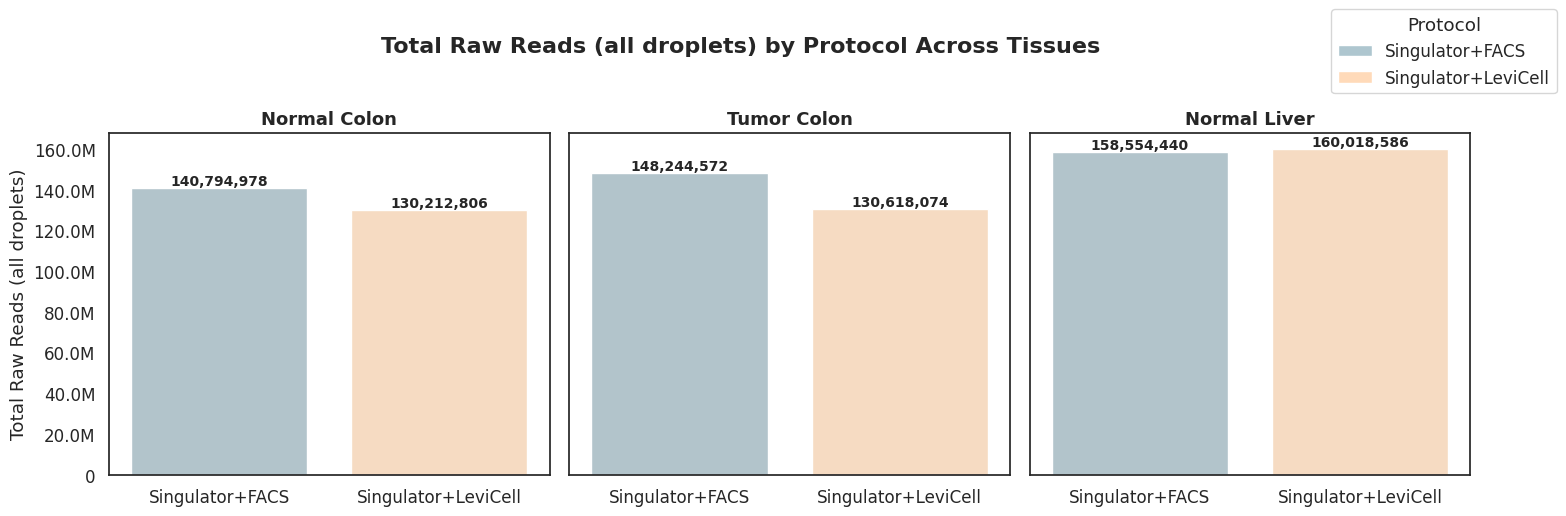

In [ ]:
# Plot the total reads per sample for all droplets
fig = plot_molecule_info_scalar_metric(
    molecule_infos=molecule_infos,
    molecule_info_metadata=molecule_info_metadata,
    metric_func=lambda df: df["reads"].sum(),  # Total reads per sample
    metric_label="Total Raw Reads (all droplets)",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "total_raw_reads_all_droplets.png"),
    bbox_inches="tight",
)

## Read in Filtered Barcodes

In [ ]:
# Load Molecule Info as Polars DataFrames
filtered_barcodes = {}

for key, (folder, tissue, protocol) in samples.items():
    file_path = os.path.join(
        READ_ONLY_DIR,
        folder,
        f"analyses/CellRangerGex-9.0.0-{folder}/outputs",
        FILTERED_BARCODES_FILE_NAME,
    )
    with gzip.open(file_path, "rt", encoding="utf-8") as f:
        filtered_barcodes[key] = f.read().splitlines()

## Filter Molecule Infos

### Functions

In [ ]:
def filter_all_molecule_infos(
    molecule_infos: Dict[str, pl.DataFrame], filtered_barcodes: Dict[str, list[str]]
) -> Dict[str, pl.DataFrame]:
    """
    Filters a dictionary of molecule_info DataFrames using corresponding filtered barcodes.

    Handles mismatched '-1' suffixes between barcode sources.

    Args:
        molecule_infos (Dict[str, pl.DataFrame]): Dictionary of Polars DataFrames keyed by sample ID.
        filtered_barcodes (Dict[str, list[str]]): Dictionary of barcode lists keyed by sample ID.

    Returns:
        Dict[str, pl.DataFrame]: Filtered molecule_info DataFrames.
    """
    filtered_molecule_infos = {}

    for key, df in molecule_infos.items():
        barcodes = filtered_barcodes[key]

        # Harmonize '-1' suffixes
        if barcodes and barcodes[0].endswith("-1") and not df["cell"][0].endswith("-1"):
            barcodes = [b.rstrip("-1") for b in barcodes]
        elif (
            df["cell"][0].endswith("-1") and barcodes and not barcodes[0].endswith("-1")
        ):
            df = df.with_columns(pl.col("cell").str.rstrip("-1"))

        filtered_molecule_infos[key] = df.filter(pl.col("cell").is_in(barcodes))

    return filtered_molecule_infos

### Load Ensembl ID to Gene Symbol Mapping

In [ ]:
# Load Ensembl to gene symbol mapping
MAPPING_FILE_PATH = os.path.join(GENE_SETS_DIR, "ensembl_to_symbol.tab")
mapping_df = pd.read_csv(
    MAPPING_FILE_PATH, sep="\t", header=None, names=["ensembl_id", "gene_symbol"]
)
ensembl_to_symbol = dict(zip(mapping_df["ensembl_id"], mapping_df["gene_symbol"]))

### Perform Filtering

In [ ]:
# Filter all molecule infos using the filtered barcodes
filtered_molecule_infos = filter_all_molecule_infos(
    molecule_infos=molecule_infos, filtered_barcodes=filtered_barcodes
)


# Convert ENSEMBL IDs to gene symbols in the filtered molecule infos
def map_ensembl_id_to_gene_symbol(molecule_info):
    """
    Maps ENSEMBL gene IDs to gene symbols in the molecule_info DataFrame.

    Args:
        molecule_info (pl.DataFrame): Polars DataFrame with a 'gene_id' column containing ENSEMBL IDs.

    Returns:
        pl.DataFrame: Updated DataFrame with an additional 'gene_symbol' column.
    """
    return molecule_info.with_columns(
        [
            pl.col("gene_id")
            .map_elements(
                lambda gid: ensembl_to_symbol.get(gid, gid), return_dtype=pl.Utf8
            )
            .alias("gene_symbol")
        ]
    )


# Apply the mapping to all filtered molecule infos
filtered_molecule_infos = {
    key: map_ensembl_id_to_gene_symbol(df)
    for key, df in filtered_molecule_infos.items()
}

## Plot Raw Reads in Filtered Cells

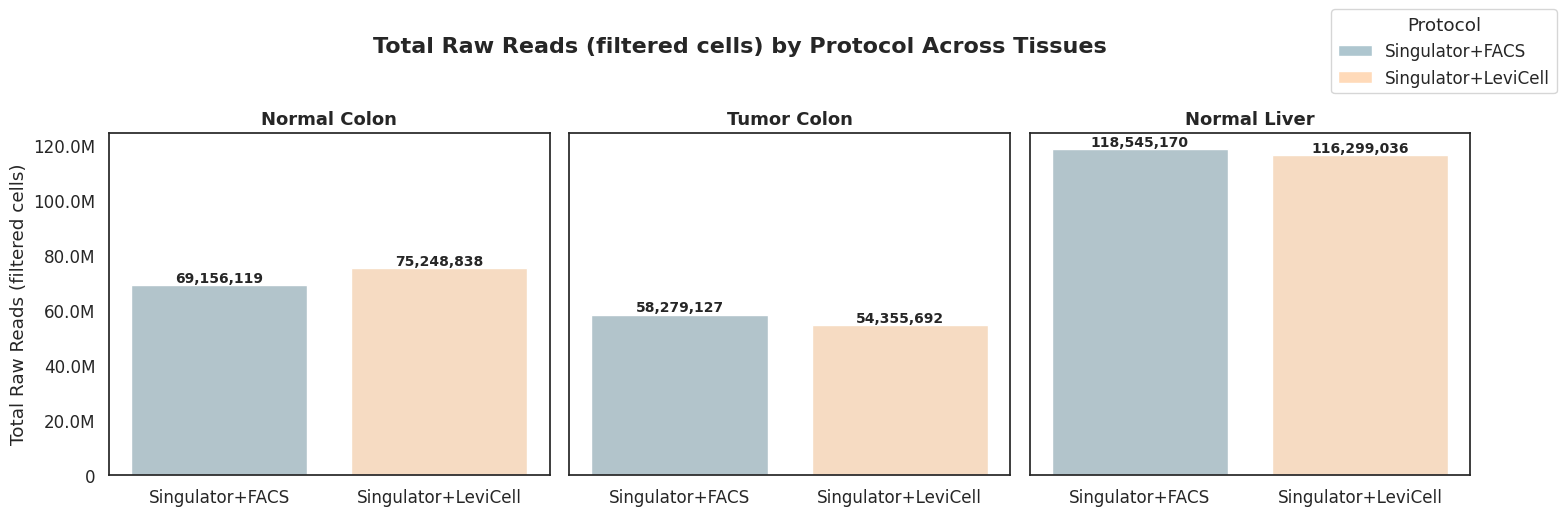

In [ ]:
# Plot the total reads per sample for all filtered cells
fig = plot_molecule_info_scalar_metric(
    molecule_infos=filtered_molecule_infos,
    molecule_info_metadata=molecule_info_metadata,
    metric_func=lambda df: df["reads"].sum(),  # Total reads per sample
    metric_label="Total Raw Reads (filtered cells)",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "total_raw_reads_filtered_cells.png"),
    bbox_inches="tight",
)

### Save Filtered Molecule Infos

In [ ]:
for key, df in filtered_molecule_infos.items():
    output_dir = os.path.join(ANALYSIS_DIR, key)
    os.makedirs(output_dir, exist_ok=True)
    out_path = os.path.join(output_dir, f"{key}_filtered_molecule_info.parquet")
    df.write_parquet(out_path)
    print(f"Saved: {out_path}")

Saved: ./data/analysis/SF_N/SF_N_filtered_molecule_info.parquet
Saved: ./data/analysis/SL_N/SL_N_filtered_molecule_info.parquet
Saved: ./data/analysis/SF_T/SF_T_filtered_molecule_info.parquet
Saved: ./data/analysis/SL_T/SL_T_filtered_molecule_info.parquet
Saved: ./data/analysis/SF_LN/SF_LN_filtered_molecule_info.parquet
Saved: ./data/analysis/SL_LN/SL_LN_filtered_molecule_info.parquet


## Downsampling

### Functions

In [ ]:
def sample_reads(x, n):
    """
    Subsample counts.

    Example:
    # data looks like
    x = [1, 2, 3, 1]
    total_counts = 7

    # draw 4 counts
    sample_indices = [0, 1, 0, 1, 1, 0, 1]  # length 7, keep 1s, drop 0s

    # get indices
    count_indices = [0, 1, 1, 2, 2, 2, 3]  # length 7, used for grouping

    # group by indices and sum
    sample_counts = [0, 1, 2, 1]
    """
    assert n < x.sum(), f"n ({n}) must be smaller than total counts ({x.sum()})"
    total_count = x.sum()
    sample_indices = np.random.binomial(1, n / total_count, total_count)
    count_indices = np.repeat(np.arange(len(x)), x)
    sample_counts = np.bincount(count_indices, weights=sample_indices).astype("int32")
    return sample_counts


def perform_downsampling(
    mol_info_df: pl.DataFrame, target_total_reads: int
) -> pl.DataFrame:
    """
    Downsamples a molecule_info DataFrame to a specified total number of reads.

    Args:
        mol_info_df (pl.DataFrame): DataFrame with a 'reads' column.
        target_total_reads (int): Desired total number of reads after downsampling.

    Returns:
        pl.DataFrame: Filtered and downsampled molecule_info DataFrame.
    """
    read_counts = mol_info_df["reads"].to_numpy()
    downsampled_reads = sample_reads(read_counts, target_total_reads)

    # Keep only molecules with >0 downsampled reads
    nonzero_mask = downsampled_reads > 0
    filtered_df = mol_info_df.filter(pl.Series(nonzero_mask))
    filtered_df = filtered_df.with_columns(
        pl.Series("reads", downsampled_reads[nonzero_mask])
    )

    return filtered_df


def run_downsampling(
    molecule_infos: Dict[str, pl.DataFrame], target_total_reads: Dict[str, int]
) -> Dict[str, pl.DataFrame]:
    """
    Runs downsampling on a dictionary of molecule_info DataFrames to a specified total number of reads.

    Args:
        molecule_infos (Dict[str, pl.DataFrame]): Dictionary of Polars DataFrames keyed by sample ID.
        target_total_reads (Dict[str, int]): Dictionary of target total reads keyed by sample ID.

    Returns:
        Dict[str, pl.DataFrame]: Downsampled molecule_info DataFrames.
    """
    downsampled_molecule_infos = {}

    for key, df in molecule_infos.items():
        downsampled_df = perform_downsampling(df, target_total_reads[key])
        downsampled_molecule_infos[key] = downsampled_df

    return downsampled_molecule_infos

### Run Downsampling

In [ ]:
# Manually set target total reads for downsampling based on total reads across all filtered cells
# Total reads should be the same across tissues
target_total_reads = {
    "SF_N": 68_000_000,
    "SL_N": 68_000_000,
    "SF_T": 53_000_000,
    "SL_T": 53_000_000,
    "SF_LN": 115_000_000,
    "SL_LN": 115_000_000,
}

downsampled_molecule_infos = run_downsampling(
    molecule_infos=filtered_molecule_infos, target_total_reads=target_total_reads
)

In [ ]:
from scipy import sparse

for sample_id in samples.keys():
    adata_path = os.path.join(INPUT_ADATA_DIR, f"{sample_id}_adata.h5ad")
    adata = sc.read_h5ad(adata_path)
    mol_info = filtered_molecule_infos[sample_id]

    # Map Ensembl IDs to gene symbols
    mol_info = mol_info.with_columns(
        [
            pl.col("gene_id")
            .map_elements(
                lambda gid: ensembl_to_symbol.get(gid, gid), return_dtype=pl.Utf8
            )
            .alias("gene_symbol")
        ]
    )

    # Aggregate UMI counts by (cell, gene_symbol)
    umi_counts_pl = (
        mol_info.group_by(["cell", "gene_symbol"])
        .agg(pl.col("umi").n_unique().alias("umi_count"))
        .pivot(values="umi_count", index="cell", on="gene_symbol")
        .fill_null(0)
    )

    # Convert to Pandas and align format
    umi_matrix = (
        umi_counts_pl.to_pandas()
        .set_index("cell")
        .rename(index=lambda x: f"{x}-1")  # match Cell Ranger barcodes
    )

    # Align with existing AnnData structure
    umi_matrix = umi_matrix.reindex(
        index=adata.obs_names, columns=adata.var_names, fill_value=0
    )

    # Add as layer to adata
    adata.layers["downsampled_umi"] = sparse.csr_matrix(umi_matrix.values)

    # Write updated file
    adata_output_path = os.path.join(OUTPUT_ADATA_DIR, f"{sample_id}_adata.h5ad")
    adata.write(adata_path)
    print(
        f"Updated {sample_id} with downsampled UMIs using gene symbols at {adata_path}"
    )

Updated SF_N with downsampled UMIs using gene symbols at ./data/analysis/adatas/SF_N_adata.h5ad
Updated SL_N with downsampled UMIs using gene symbols at ./data/analysis/adatas/SL_N_adata.h5ad
Updated SF_T with downsampled UMIs using gene symbols at ./data/analysis/adatas/SF_T_adata.h5ad
Updated SL_T with downsampled UMIs using gene symbols at ./data/analysis/adatas/SL_T_adata.h5ad
Updated SF_LN with downsampled UMIs using gene symbols at ./data/analysis/adatas/SF_LN_adata.h5ad
Updated SL_LN with downsampled UMIs using gene symbols at ./data/analysis/adatas/SL_LN_adata.h5ad


## Gene Discovery Downsampled Curves

### Computation Functions

In [ ]:
def compute_gene_discovery_downsampled_stats(
    filtered_molecule_infos: Dict[str, pl.DataFrame],
    total_reads: Dict[str, int],
    n_steps: int = 10,
    min_reads: int = 10_000_000,
) -> Dict[str, Dict[str, list]]:
    """
    Compute gene discovery statistics (median UMIs, genes per cell, and mean reads per cell) by downsampling.

    Args:
        filtered_molecule_infos (Dict[str, pl.DataFrame]): Dict of molecule_info DataFrames keyed by sample ID.
        total_reads (Dict[str, int]): Dict of target total reads per sample.
        n_steps (int): Number of evenly spaced read levels to compute between min_reads and max.
        min_reads (int): Minimum number of reads to start downsampling from.

    Returns:
        Dict[str, Dict[str, list]]: Results keyed by sample with read depths and median stats.
    """
    results = {
        sample_id: {
            "total_reads": [],
            "mean_reads": [],
            "median_umis": [],
            "median_genes": [],
        }
        for sample_id in filtered_molecule_infos
    }

    for sample_id, mol_info in filtered_molecule_infos.items():
        max_reads = total_reads[sample_id]
        steps = np.linspace(min_reads, max_reads, n_steps, dtype=int)

        for target in steps:
            # Downsample reads
            downsampled_df = perform_downsampling(mol_info, target)

            # Mean reads per cell
            mean_reads = (
                downsampled_df.group_by("cell")
                .agg(pl.sum("reads").alias("reads"))
                .select(pl.col("reads").mean())
                .item()
            )

            # Get unique UMIs per (cell, gene)
            umi_counts = downsampled_df.group_by(["cell", "gene_id"]).agg(
                pl.col("umi").n_unique().alias("umi_count")
            )

            # Sum UMIs and count genes with ≥1 UMI per cell
            grouped = umi_counts.group_by("cell").agg(
                [pl.sum("umi_count").alias("umis"), pl.count("gene_id").alias("genes")]
            )

            median_umis = grouped["umis"].median()
            median_genes = grouped["genes"].median()

            # Append to results
            results[sample_id]["total_reads"].append(int(target))
            results[sample_id]["mean_reads"].append(float(mean_reads))
            results[sample_id]["median_umis"].append(float(median_umis))
            results[sample_id]["median_genes"].append(float(median_genes))

    return results

### Plotting Functions

In [47]:
def plot_downsampling_curve_by_metric(
    summary_stats: Dict[str, Dict[str, np.ndarray]],
    sample_metadata: Dict[str, tuple],
    protocol_color_palette: Dict[str, str],
    metric_key: str = "median_umis",
    match_x_axis: bool = False,
) -> plt.Figure:
    """
    Plots a downsampling curve for the specified metric across tissues.

    Args:
        summary_stats: Dict mapping sample_id to bootstrapped stats.
        sample_metadata: Dict mapping sample_id to (sample_name, tissue, protocol).
        protocol_color_palette: Mapping from protocol to color.
        metric_key: Either "median_umis" or "median_genes".

    Returns:
        Matplotlib Figure.
    """
    if metric_key not in ["median_umis", "median_genes"]:
        raise ValueError("metric_key must be 'median_umis' or 'median_genes'")

    metric_label = (
        "Median UMIs per Cell"
        if metric_key == "median_umis"
        else "Median Genes per Cell"
    )
    title = f"{metric_label} vs Total Reads"

    tissues = list(dict.fromkeys(tissue for _, tissue, _ in sample_metadata.values()))
    n_tissues = len(tissues)

    # Map tissue to sample_ids
    tissue_to_samples = {tissue: [] for tissue in tissues}
    for sample_id, (_, tissue, _) in sample_metadata.items():
        tissue_to_samples[tissue].append(sample_id)

    # Create subplots
    fig, axes = plt.subplots(1, n_tissues, figsize=(6 * n_tissues, 5), sharey=True)
    if n_tissues == 1:
        axes = [axes]

    if match_x_axis:
        # Match x-axis limits across subplots
        all_x = np.concatenate(
            [
                summary_stats[sample_id]["total_reads_mean"]
                for sample_id in summary_stats
            ]
        )
        xmin, xmax = all_x.min(), all_x.max()

        for ax in axes:
            ax.set_xlim(xmin, xmax)

    for i, tissue in enumerate(tissues):
        ax = axes[i]
        for sample_id in tissue_to_samples[tissue]:
            stats = summary_stats[sample_id]
            _, _, protocol = sample_metadata[sample_id]
            color = protocol_color_palette.get(protocol, "gray")

            ax.errorbar(
                stats["total_reads_mean"],
                stats[f"{metric_key}_mean"],
                yerr=stats[f"{metric_key}_std"],
                label=protocol,
                marker="o",
                capsize=3,
                color=color,
            )

        ax.set_title(tissue, fontsize=13, weight="bold")
        ax.set_xlabel("Total Reads")
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(adaptive_formatter))
        if i == 0:
            ax.set_ylabel(metric_label)

    fig.suptitle(f"{title}", fontsize=16, weight="bold")
    fig.legend(
        handles=[
            mpl.patches.Patch(color=c, label=p)
            for p, c in protocol_color_palette.items()
        ],
        title="Protocol",
        loc="upper right",
        bbox_to_anchor=(1.05, 1),
    )
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

### Calculate Summary Stats

Warning: cell below takes a very long time to complete - best to use a separate script with multiprocessing to parallelize operations:

In [ ]:
from collections import defaultdict
import numpy as np

n_bootstraps = 10
n_steps = 10
min_reads = 10_000_000

# Run 10 bootstraps and store each replicate
bootstrap_results = defaultdict(lambda: defaultdict(list))

for i in range(n_bootstraps):
    rarefaction_results = compute_gene_discovery_downsampled_stats(
        filtered_molecule_infos=filtered_molecule_infos,
        total_reads=target_total_reads,
        n_steps=n_steps,
        min_reads=min_reads,
    )
    for sample_id in rarefaction_results:
        for key in ["total_reads", "mean_reads", "median_umis", "median_genes"]:
            bootstrap_results[sample_id][key].append(
                rarefaction_results[sample_id][key]
            )

# Summarize into plot-ready format
summary_stats = defaultdict(dict)
for sample_id, stats in bootstrap_results.items():
    # Each key is a list of n_bootstraps × n_steps
    total_reads_array = np.array(stats["total_reads"])  # shape: (n_bootstraps, n_steps)
    mean_reads_array = np.array(stats["mean_reads"])  # shape: (n_bootstraps, n_steps)
    median_umis_array = np.array(stats["median_umis"])
    median_genes_array = np.array(stats["median_genes"])

    # Mean and std across bootstraps
    summary_stats[sample_id]["total_reads_mean"] = total_reads_array.mean(axis=0)
    summary_stats[sample_id]["total_reads_std"] = total_reads_array.std(axis=0)

    summary_stats[sample_id]["mean_reads_mean"] = mean_reads_array.mean(axis=0)
    summary_stats[sample_id]["mean_reads_std"] = mean_reads_array.std(axis=0)

    summary_stats[sample_id]["median_umis_mean"] = median_umis_array.mean(axis=0)
    summary_stats[sample_id]["median_umis_std"] = median_umis_array.std(axis=0)

    summary_stats[sample_id]["median_genes_mean"] = median_genes_array.mean(axis=0)
    summary_stats[sample_id]["median_genes_std"] = median_genes_array.std(axis=0)

Save info if desired

In [ ]:
import dill

with open(os.path.join(ANALYSIS_DIR, "bootstrap_results.dill"), "wb") as f:
    dill.dump(bootstrap_results, f)

with open(os.path.join(ANALYSIS_DIR, "summary_stats.dill"), "wb") as f:
    dill.dump(summary_stats, f)

In [ ]:
import dill
import os

with open(os.path.join(ANALYSIS_DIR, "bootstrap_results.dill"), "rb") as f:
    bootstrap_results = dill.load(f)

with open(os.path.join(ANALYSIS_DIR, "summary_stats.dill"), "rb") as f:
    summary_stats = dill.load(f)

## Plot Curves

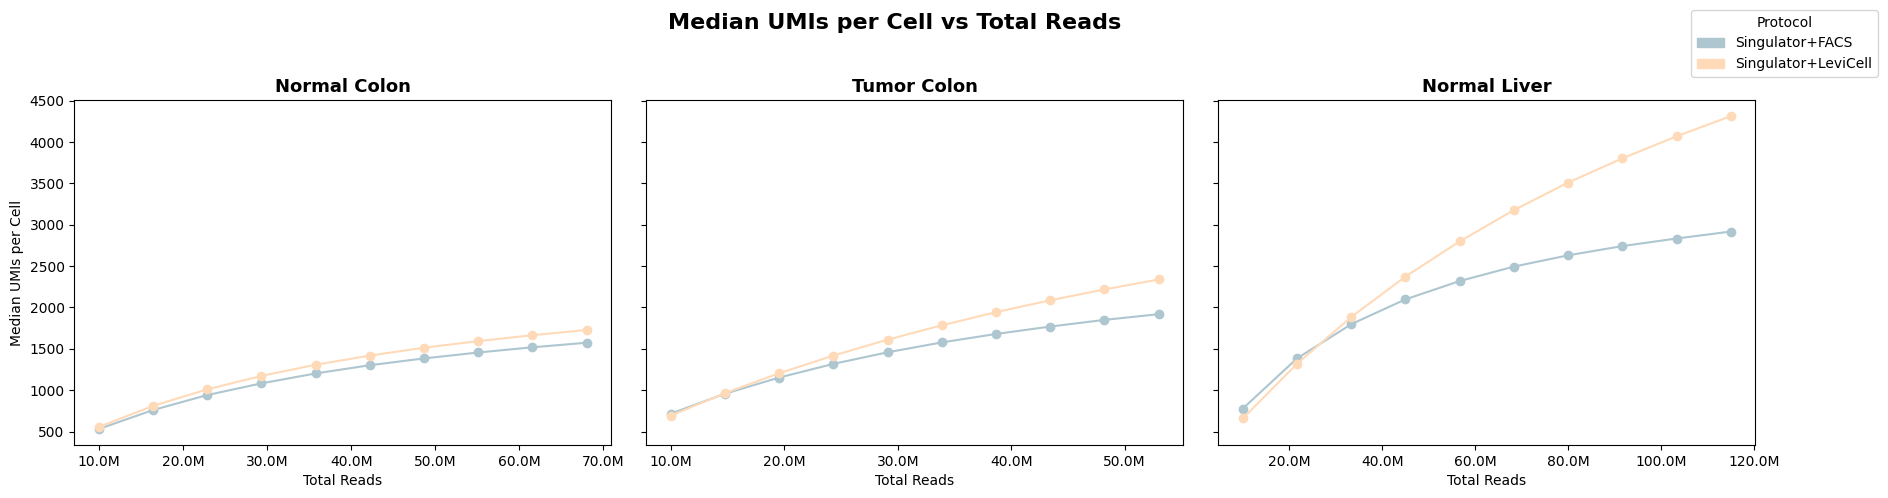

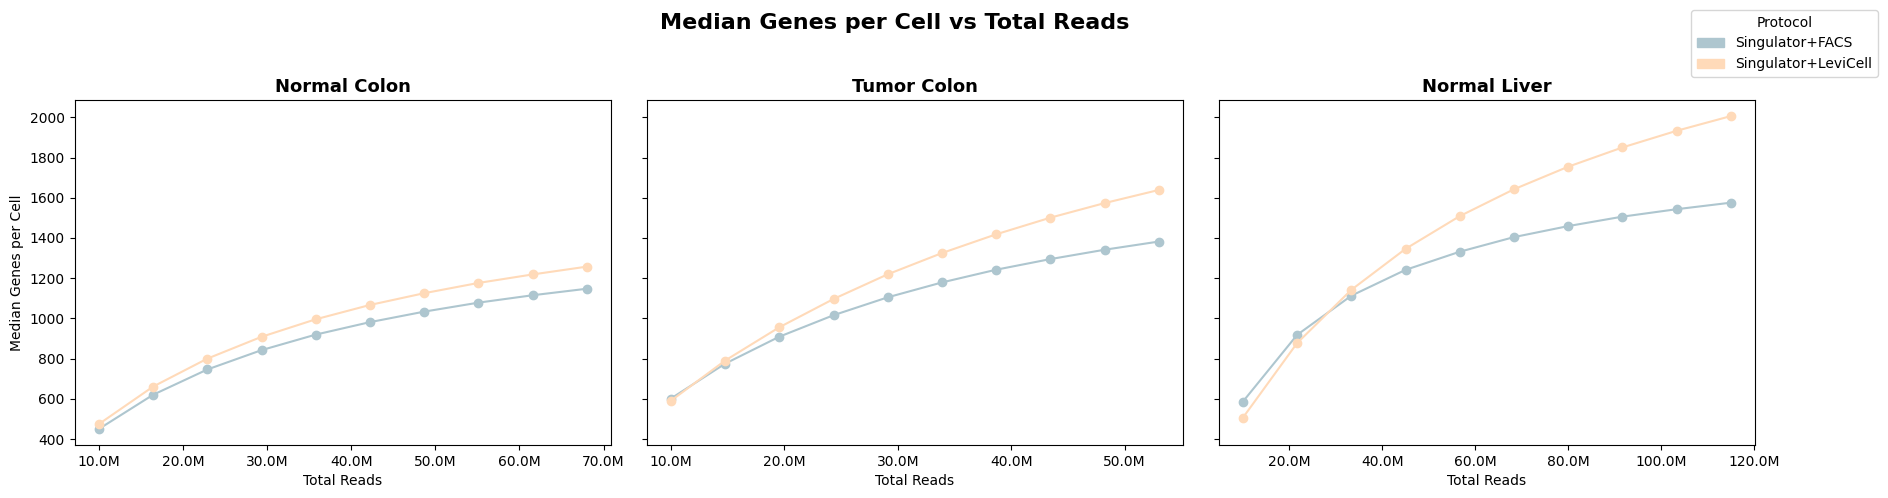

In [49]:
fig_umis = plot_downsampling_curve_by_metric(
    summary_stats,
    samples,
    protocol_color_palette,
    metric_key="median_umis",
    match_x_axis=False,
)
fig_genes = plot_downsampling_curve_by_metric(
    summary_stats,
    samples,
    protocol_color_palette,
    metric_key="median_genes",
    match_x_axis=False,
)

# Save the figures
fig_umis.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "downsampling_curve_median_umis.png"),
    bbox_inches="tight",
)
fig_genes.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "downsampling_curve_median_genes.png"),
    bbox_inches="tight",
)